<a href="https://colab.research.google.com/github/StillWork/AIDD-2208-add/blob/main/c_86_2_GenerativeModel_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE를 이용한 분자 생성 모델

- Variational Autoencoder를 이용하여 신약 후보 분자를 생성하는 모델을 구현한다
- 기존의 화합물의 특성을 예측하는 것이 아니라 open space에서 새로운 화합물 구조를 생성한다
- 입력 분자의 표현형은 SMILES 문자열로 처리하지 않고 그래프 형태로 표현하도록 수정
- 참고블로그 [Drug Molecule Generation with VAE](https://keras.io/examples/generative/molecule_generation/)
- [동영상VAE(10:30)](https://www.youtube.com/watch?v=fcvYpzHmhvA)

## 개요
- 참고 논문 1: [Automatic chemical design using a data-driven continuous representation of molecules](https://arxiv.org/abs/1610.02415)
- 그림 (a): 모델은 세 부분으로 구성된다: Encoder, Decoder, Predictor
 - 인코더는 SMILES과 같은 디지털 표현형을 받아 분자를 연속 공간의 벡터(연속형 값들로 구성된 임베딩 벡터)로 변환한다
 - 디코더는 연속형 벡터값을 새로운 분자를 나타내는 SMILES을 생성한다
 - Predictor는 분자의 연속형 벡터로부터 화학적인 특성을 예측한다(MLP로 구현). 이를 이용해 원하는 특성의 화합물을 찾는다
 - 오토인코더의 손실함수와 예측기의 손실함수를 더해서 사용한다. 즉, joint training으로 두가지 목표를 동시에 달성하도록 한다

<img src="https://raw.githubusercontent.com/StillWork/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202022-11-13%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.46.43.png?raw=1"  align='center'>  


- 그림 (b): 연속형 값으로 표현되는 잠재 공간에서 경사하강기반의 최적화 탐색을 수행한다. 새로 생성되는 분자가 원하는 속성을 갖는 잠재 벡터로부터 가장 가까운 SMILES를 얻을 수 있다. 
 - 이 후보 물질이 원하는 특성을 갖는지는 실험을 통해서 최종 확인해야 한다.

- 참고 논문 2: [MolGAN: An implicit generative model for small molecular graphs](https://arxiv.org/abs/1805.11973)

 - MolGAN 예제:
[WGAN-GP with R-GCN for the generation of small molecular graphs](https://bit.ly/3pU6zXK) 

## RDKit

- SMILES로 표현된 분자를 mol 객체로 변환하거나 mol 객체로부터 분자의 다양한 특성들을 추출하는데 사용한다
 

In [1]:
!pip -q install rdkit-pypi

     |████████████████████████████████| 29.5 MB 51.4 MB/s 


In [2]:
import ast  # abstract syntax tree
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage
%config InlineBackend.figure_format = 'retina'
RDLogger.DisableLog("rdApp.*")

## Dataset

- 사용할 데이터셋 [**ZINC – A Free Database of Commercially Available Compounds for
Virtual Screening**](https://bit.ly/3IVBI4x) 
 - 분자의 SMILE, **logP** (water–octanal partition coefficient), **SAS** (synthetic
accessibility score), **QED** (Qualitative Estimate of Drug-likeness)를 제공한다

In [3]:
!curl -L -o 250k_rndm_zinc_drugs_clean_3.csv \
   https://www.dropbox.com/s/61zerjzicxgk1lz/250k_rndm_zinc_drugs_clean_3.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   140    0   140    0     0    334      0 --:--:-- --:--:-- --:--:--   335
100   340  100   340    0     0    405      0 --:--:-- --:--:-- --:--:--     0
100 21.5M  100 21.5M    0     0  9899k      0  0:00:02  0:00:02 --:--:-- 27.5M


In [4]:
df = pd.read_csv("250k_rndm_zinc_drugs_clean_3.csv")
print(df.shape)
df.head()

(249455, 4)


,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [5]:
df['smiles'] = df['smiles'].apply(lambda s: s.replace('\n', ''))
df[:3]

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633


## Hyperparameters

In [6]:
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br"]'

bond_mapping = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3}
bond_mapping.update(
    {0: BondType.SINGLE, 1: BondType.DOUBLE, 2: BondType.TRIPLE, 3: BondType.AROMATIC}
)
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

MAX_MOLSIZE = max(df["smiles"].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)
atom_mapping

{'C': 0,
 'B': 1,
 'F': 2,
 'I': 3,
 'H': 4,
 'O': 5,
 'N': 6,
 'S': 7,
 'P': 8,
 'Cl': 9,
 'Br': 10,
 0: 'C',
 1: 'B',
 2: 'F',
 3: 'I',
 4: 'H',
 5: 'O',
 6: 'N',
 7: 'S',
 8: 'P',
 9: 'Cl',
 10: 'Br'}

In [7]:
BATCH_SIZE = 100
EPOCHS = 10

VAE_LR = 5e-4    # learning rate
NUM_ATOMS = 120  # Maximum number of atoms

ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 435  # Size of the latent space


def smiles_to_graph(smiles):
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


def graph_to_molecule(graph):
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule


## 훈련 데이터 준비

In [8]:
train_df = df.sample(frac=0.75, random_state=42)  # random state is a seed value
train_df.reset_index(drop=True, inplace=True)

adjacency_tensor, feature_tensor, qed_tensor = [], [], []
for idx in range(8000):
    adjacency, features = smiles_to_graph(train_df.loc[idx]["smiles"])
    qed = train_df.loc[idx]["qed"]
    adjacency_tensor.append(adjacency)
    feature_tensor.append(features)
    qed_tensor.append(qed)

adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)
qed_tensor = np.array(qed_tensor)

In [9]:
train_df.shape

(187091, 4)

In [10]:
adjacency_tensor[0], feature_tensor[0], qed_tensor[0]

(array([[[0., 1., 0., ..., 0., 0., 0.],
         [1., 0., 1., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0

# 그래프 컨볼류션 계층 설계

In [11]:
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)


## Encoder,  Decoder 구현

- 인코더는 분자의 graph adjacency matrix와 feature matrix를 입력으로 받는다
- 이를 Graph Convolution layer에서 처리하고 flatten 시킨 뒤에 여러 Dense 계층을 통과시켜 `z_mean`과 `log_var`을 구한다 (이것이 분자의 latent-space representation이다) 
- Graph Convolution layer로 [Relational graph convolution[(https://arxiv.org/pdf/2107.10015.pdf)을 사용한다
 - adjacency tensor(A), feature tensor(H), inverse diagonal degree tensor(D),weight tensor(W)를 사용한다
 - degree tensor의 diagonal에는 bond 타입(relation)을 표현하기 위해서 각 원자에 연결된 결합수를 나타낸다
- 디코더는 잠재 벡터를 입력으로 받고 해당하는 분자의 graph adjacency matrix와 feature matrix를 예측하여 생성한다

In [12]:
def get_encoder(
    gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units, dropout_rate
):
    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)

    # Propagate through one or more graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )
    # Reduce 2-D representation of molecule to 1-D
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Propagate through one or more densely connected layers
    for units in dense_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)

    z_mean = layers.Dense(latent_dim, dtype="float32", name="z_mean")(x)
    log_var = layers.Dense(latent_dim, dtype="float32", name="log_var")(x)

    encoder = keras.Model([adjacency, features], [z_mean, log_var], name="encoder")

    return encoder


def get_decoder(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
    latent_inputs = keras.Input(shape=(latent_dim,))

    x = latent_inputs
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # Map outputs of previous layer (x) to [continuous] adjacency tensors (x_adjacency)
    x_adjacency = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape))(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify tensors in the last two dimensions
    x_adjacency = (x_adjacency + tf.transpose(x_adjacency, (0, 1, 3, 2))) / 2
    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)

    # Map outputs of previous layer (x) to [continuous] feature tensors (x_features)
    x_features = keras.layers.Dense(tf.math.reduce_prod(feature_shape))(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)

    decoder = keras.Model(
        latent_inputs, outputs=[x_adjacency, x_features], name="decoder"
    )

    return decoder


## Sampling 계층 구현

In [13]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_log_var)[0]
        dim = tf.shape(z_log_var)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## VAE 모델 구축

- 모델은 다음과 같이 4가지 손실을 최적화하도록 훈련한다
 * Categorical crossentropy: 오토인코더 모델의 reconstruction accuracy를 측정
 * KL divergence loss
 * Property prediction loss: 속성 예측 모델이 예측한 값과 실제값의 MSE. QED 예측 등을 반영하여 최적화를 가이드할 수 있다
 * Graph loss (gradient penalty): 신경망의 성능 개선을 위해서 1-Lipschitz continuity 등을 고려 (norm of the gradient가 1 이하가 되도록 제한)

In [14]:
class MoleculeGenerator(keras.Model):
    def __init__(self, encoder, decoder, max_len, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.property_prediction_layer = layers.Dense(1)
        self.max_len = max_len

        self.train_total_loss_tracker = keras.metrics.Mean(name="train_total_loss")
        self.val_total_loss_tracker = keras.metrics.Mean(name="val_total_loss")

    def train_step(self, data):
        adjacency_tensor, feature_tensor, qed_tensor = data[0]
        graph_real = [adjacency_tensor, feature_tensor]
        self.batch_size = tf.shape(qed_tensor)[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, qed_pred, gen_adjacency, gen_features = self(
                graph_real, training=True
            )
            graph_generated = [gen_adjacency, gen_features]
            total_loss = self._compute_loss(
                z_log_var, z_mean, qed_tensor, qed_pred, graph_real, graph_generated
            )

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.train_total_loss_tracker.update_state(total_loss)
        return {"loss": self.train_total_loss_tracker.result()}

    def _compute_loss(
        self, z_log_var, z_mean, qed_true, qed_pred, graph_real, graph_generated
    ):

        adjacency_real, features_real = graph_real
        adjacency_gen, features_gen = graph_generated

        adjacency_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.categorical_crossentropy(adjacency_real, adjacency_gen),
                axis=(1, 2),
            )
        )
        features_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.categorical_crossentropy(features_real, features_gen),
                axis=(1),
            )
        )
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), 1
        )
        kl_loss = tf.reduce_mean(kl_loss)

        property_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(qed_true, qed_pred)
        )

        graph_loss = self._gradient_penalty(graph_real, graph_generated)

        return kl_loss + property_loss + graph_loss + adjacency_loss + features_loss

    def _gradient_penalty(self, graph_real, graph_generated):
        # Unpack graphs
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        # Generate interpolated graphs (adjacency_interp and features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        # Compute the logits of interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            _, _, logits, _, _ = self(
                [adjacency_interp, features_interp], training=True
            )

        # Compute the gradients with respect to the interpolated graphs
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Compute the gradient penalty
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis=(-1))
        )

    def inference(self, batch_size):
        z = tf.random.normal((batch_size, LATENT_DIM))
        reconstruction_adjacency, reconstruction_features = model.decoder.predict(z)
        # obtain one-hot encoded adjacency tensor
        adjacency = tf.argmax(reconstruction_adjacency, axis=1)
        adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
        # Remove potential self-loops from adjacency
        adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
        # obtain one-hot encoded feature tensor
        features = tf.argmax(reconstruction_features, axis=2)
        features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
        return [
            graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
            for i in range(batch_size)
        ]

    def call(self, inputs):
        z_mean, log_var = self.encoder(inputs)
        z = Sampling()([z_mean, log_var])

        gen_adjacency, gen_features = self.decoder(z)

        property_pred = self.property_prediction_layer(z_mean)

        return z_mean, log_var, property_pred, gen_adjacency, gen_features


# 모델 훈련|

In [18]:
vae_optimizer = tf.keras.optimizers.Adam(learning_rate=VAE_LR)

encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0.0,
)
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

model = MoleculeGenerator(encoder, decoder, MAX_MOLSIZE)

model.compile(vae_optimizer)
history = model.fit([adjacency_tensor, feature_tensor, qed_tensor], epochs=EPOCHS)

Epoch 1/10
250/250 [==============================] - 8s 22ms/step - loss: 69016.2273
Epoch 2/10
250/250 [==============================] - 6s 22ms/step - loss: 68856.8177
Epoch 3/10
250/250 [==============================] - 6s 22ms/step - loss: 68837.4289
Epoch 4/10
250/250 [==============================] - 5s 22ms/step - loss: 68840.8077
Epoch 5/10
250/250 [==============================] - 5s 22ms/step - loss: 68838.3622
Epoch 6/10
250/250 [==============================] - 6s 22ms/step - loss: 68821.2608
Epoch 7/10
250/250 [==============================] - 5s 22ms/step - loss: 68815.6577
Epoch 8/10
250/250 [==============================] - 6s 22ms/step - loss: 68805.8894
Epoch 9/10
250/250 [==============================] - 5s 22ms/step - loss: 68805.8191
Epoch 10/10
250/250 [==============================] - 6s 22ms/step - loss: 68809.3169


## Inference

- 학습한 모델을 사용하여 잠재 공간의 다른 점에 해당하는 분자를 생성

### 모델을 이용하여 새로운 분자 생성

32/32 [==============================] - 0s 4ms/step


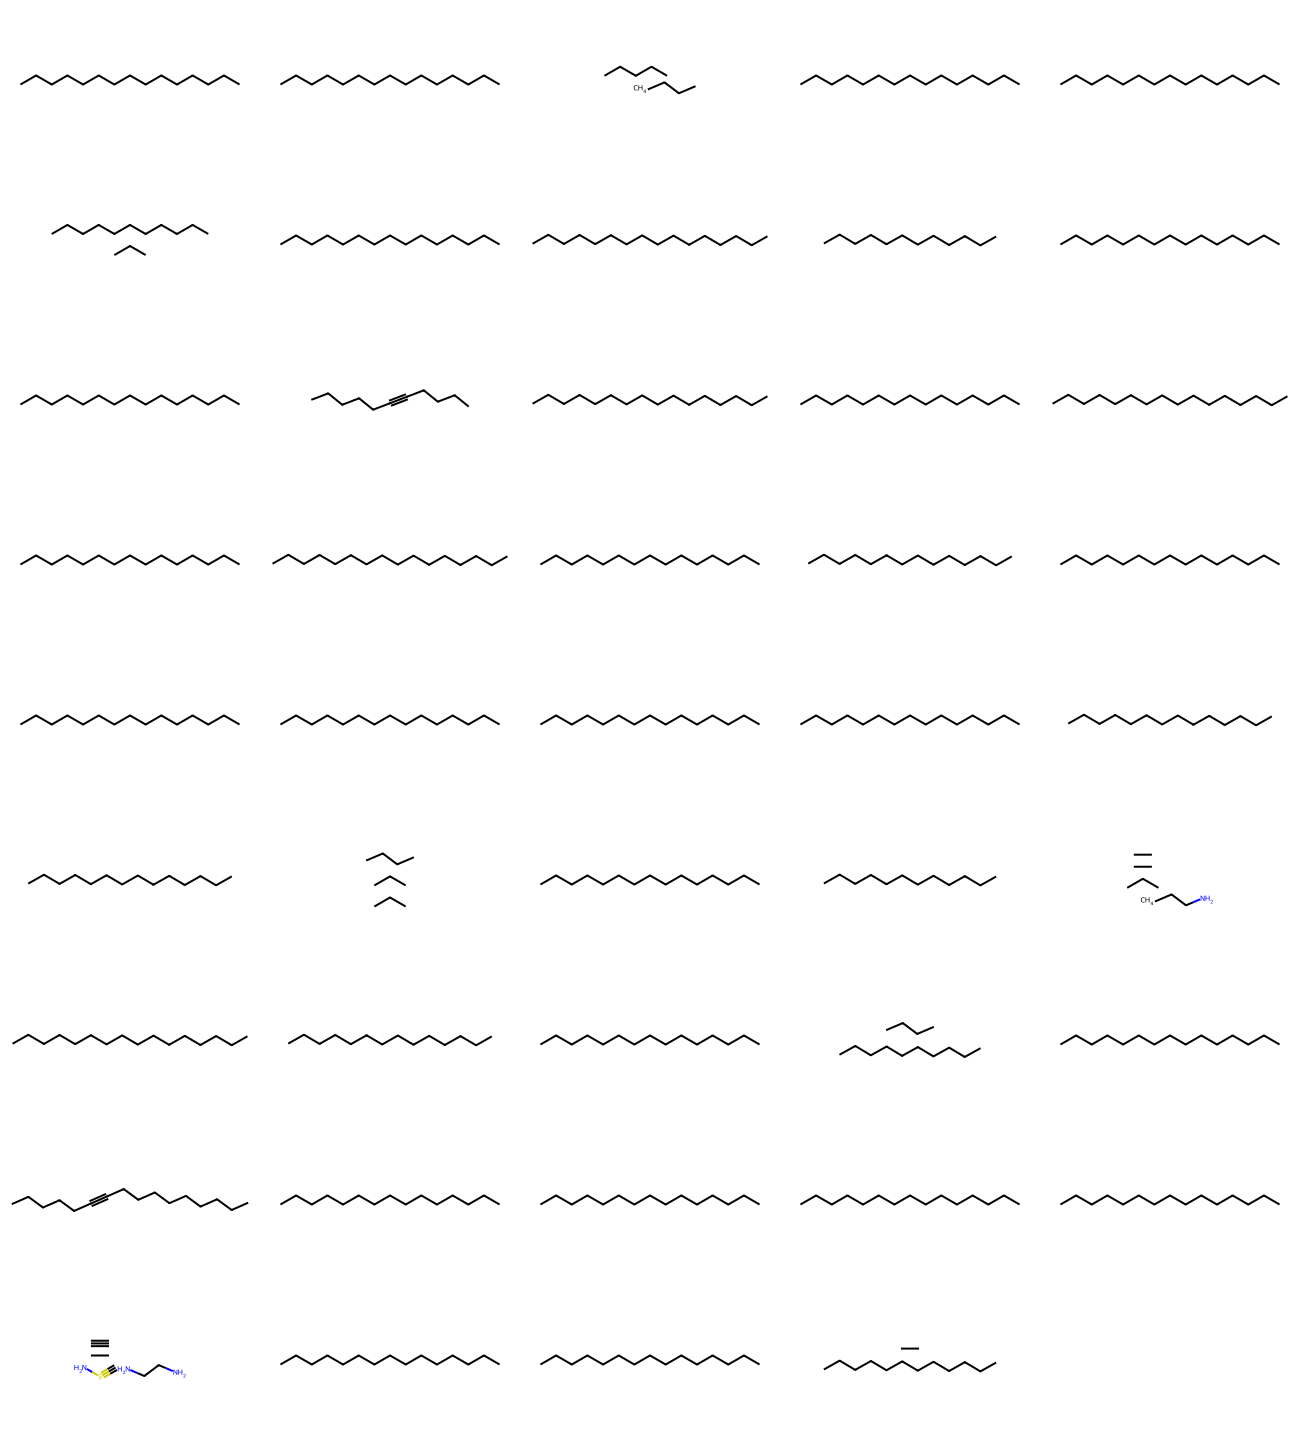

In [42]:
molecules = model.inference(1000)
MolsToGridImage(
    [m for m in molecules if m is not None][:1000], molsPerRow=5, subImgSize=(260, 160)
)

### Display latent space clusters with respect to molecular properties (QAE)

4/4 [==============================] - 0s 4ms/step
(100, 435)


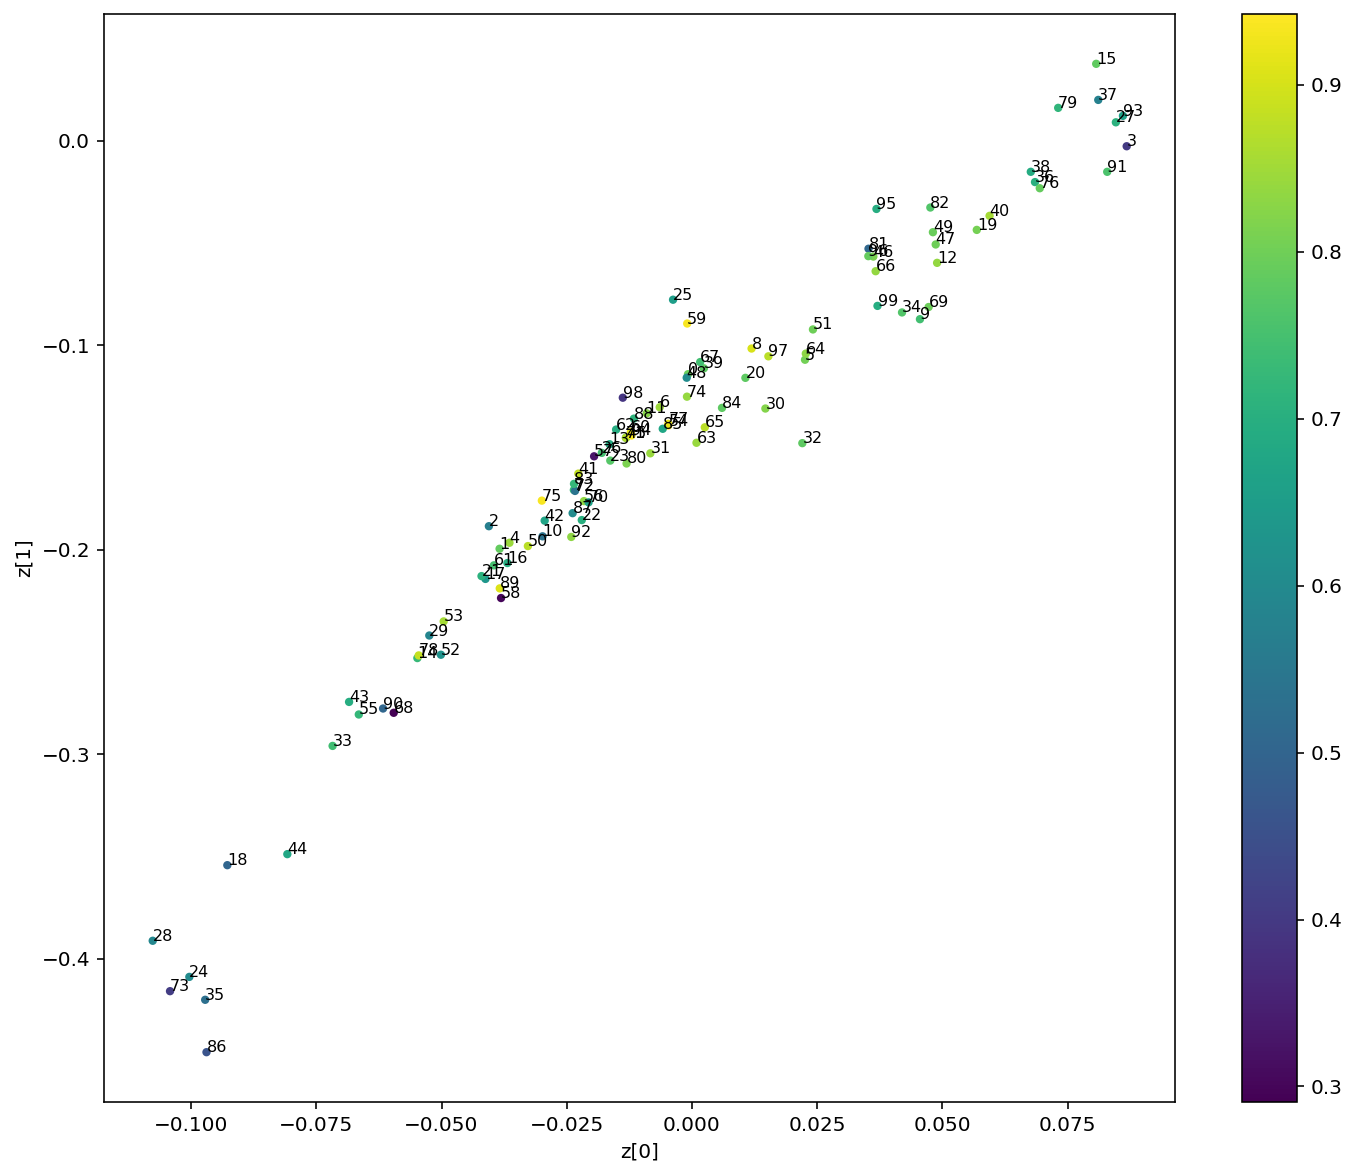

In [41]:
def plot_latent(vae, data, labels):
    # display a 2D plot of the property in the latent space
    z_mean, _ = vae.encoder.predict(data)
    print(z_mean.shape)
    plt.figure(figsize=(12, 10))
    numbers = np.arange(len(z_mean))
    plt.scatter(z_mean[:,0], z_mean[:,1], c=labels, s=10)
    for i in numbers:
      plt.text(z_mean[:,0][i], z_mean[:,1][i], str(i), size=8)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

N= 100
plot_latent(model, [adjacency_tensor[:N], feature_tensor[:N]], qed_tensor[:N])